## --------MARKING LANE LINES AND DETERMINING RADIUS OF CURVATURE OF ROAD ------

#### INTRODUCTION:
Lane detection and radius of curvature determination are very much important for any high level algorithm to predict the required steering angle and accelaration in sel-driven cars. So, algorithms developed to identify lane lines and curvature along with the position of the vehicle in the lane should be fast and accurate enough to be observed in real-time. In this project I try to present a novel idea based on advanced computer vision techniques that stand still in most of the conditions. The important aspects that any algorithm should look into while solving for this problem are shadows and sudden changes in sun light intensitties. So, we convert our image space from RGB to HSV or HSL and create thresholds on saturation values for Region of interest.

#### METHODOLOGY:
This problem is split into two sub-problems. The first sub-problem deals with identifying potential regions inthe image that can contribute to be part of a lane. This is achieved by applying cv techniques that shall be discussed clearly in upcoming steps. The second sub-problem deals with marking lane lines using windows on the original frame to compute radius of curvature and removal of noise and disttubances in the lane lines obtianed by taking into consideration of previous frame lane data.

#### Problem 1: Creating a mask that can detect lanes
The computer vision techniques employed in creating a mask are undistorting, perspective transformation, color masking and sobel filter. All these techniques are used as functions from OpenCV libraries. The design heirarchy is divided into following steps.

1. Read an image from the dataset and undistort using pre-computed distortion camera matrix.
2. Apply perspective transform on undistorted image to have a bird's eye view of the road. Warping the image to right region of interest does good help in further processing of the frame.
3. Shifting the colour space from RGB to either HSV or HSL helps to figure out more data with less effort. HSV values for Yellow range from [0,100,100] to [80,255,255], and for white colour they range from [0,0,210] to [200,50,255]. 'H' or HUE stands for the colour itself , 'S' stands for SATURATION or the amount of colour, and 'V' stands for VALUE or the amount of brighness applied over that colour. As the important aspect of this problem is to find lanes even with heavy variations of brightness, shifting the colour space from RGB to HSV will do a good job. 
4. Once the color mask is applied on the image the next step is to detect the edges from the masked image. Sobel filter is applied on H, L channels of the warped image as these channels show very mimimal change with lighting variations. Sobel filter is applied along X and Y directons independently and a bitwise OR operation is performed on the the masks to obtain a final mask. After many number of iterations the threshold values from 50 to 225 were choosen to be appropriate.
5. For the final step of stage 1 pixels from Colour and Sobel masks are combined to obtain potential lane locations.

#### Problem 2: Computing Curvature
The above methodologies work only in the conditions when the lanes are visible to a good extent, so we need some better way that can propogate the lane forward when there are small disturbances covering parts of the road, like snow, dust, wear and tear. For this reason we run a small window of 50 pixels along the center of the lanes computed in the previous frames. This windowing technique applied from the second frame can help reduce the computation time to a great extent and also helps in continuous propogation of lane. Two correction steps are also followed along with the previous steps to keep the lane smooth, they are outlier removal and smoothing. Pixels are marked as outliers if their width is found to be less than 5 pixles and if coffecient change is more than 0.01 is introduced because of it. A factor of 0.01 is taken keeping vehicle turn radius as atleast 7m corresponding to short side lane  curvature. Smoothing is achieved by adopting 90 percent of previous coefficients into the present quadratic coefficient values. Using these coefficients of new polynomial fit we compute the curvature of the lane and relative location of the car in the lane. Followings steps are the pipeline for this stage.

1. Consider only half of the image that is masked and compute histogram, and we find the lane locations at the two peaks of histogram corresponding to left and right lanes of the road in the masked image.
2. The next step is placing a window of size 50x50 pixels on the bottom 10th part of the image by centering the windows the peaks located in the previous step and propagate forward in the same way to next sections of the image and to upcoming frames. In case if no peaks were found in the previous link we place the window at a location with offset from previous computed center.
3. Now we try fit a quadratic fit polynomial using numpys polyfit function.
4. If the current frame is not the first frame we follow the pervious steps for computation and the next step is outlier removal. If a lane was found with less than 5 pixels it is discarded and the previous coefficients are used in the place of current.
5. However smoothing is required on the lanes, so previous curve coefficients are used along the current values. This helps smooth shifting of lane curvature.
6. Finally the lane curvature and position of car on the lane are computed and reverse marked on the unwarped perspective image.


---------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------

## Problem1 Solution

## Import necessary packages and define necessary functions

In [2]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import pickle
import math
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import Image as ipimag
from PIL import Image as pimag
import glob
outdir= "modelsol"
pi = 3.14159
% matplotlib inline

In [3]:
def undistort_image(image,mtx,dist):
    undist_image = cv2.undistort(image,mtx,dist,None,mtx)
    return undist_image
def gaussian_blur(image,kernel=5):
    blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return blur_image

def clahe(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(6,6))    
    transform = clahe.apply(v)
    res= cv2.merge((h,s,transform))
    res = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    return res

# Calculate directional gradient
# Apply threshold
def abs_sobel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

# Calculate gradient magnitude
# Apply threshold
def mag_thresh(img, sobel_kernel=3, thresh=(20,100)):
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

# Calculate gradient direction
# Apply threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))    
    binary_output = 0*grad_s 
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

# Apply Gaussian adaptive thresholding
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

# Apply perspective transform
def warp_image(img,src,dst,img_size):
    Mat = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, Mat, img_size, flags=cv2.INTER_LINEAR)
    Mat_inv = cv2.getPerspectiveTransform(dst, src)
    return warped,Mat,Mat_inv



# Return mask from HSV 
def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask

# Apply color mask to image
def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

# Moving average
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


--------------------------------------------------------------------------------------------------------------------------------------------

### Step1: Read the image and undistort using undistortion matrix obtained from camera caliberation

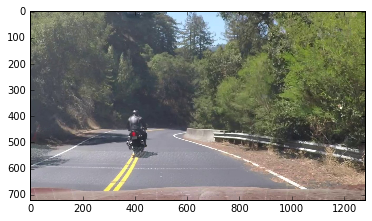

In [257]:
cal = pickle.load(open("camera_calibration.pkl" , "rb"))
mtx_camera = cal[0]
dist_camera = cal[1]
image = mpimg.imread(open('video2image/video2imageframe92.jpg','rb'))
plt.imshow(image)
plt.show()
#plt.axis('off');

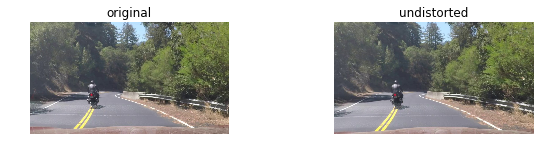

In [258]:
undist_image = undistort_image(image,mtx_camera,dist_camera)
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(undist_image)
plt.title('undistorted')
plt.axis('off');
plt.show()

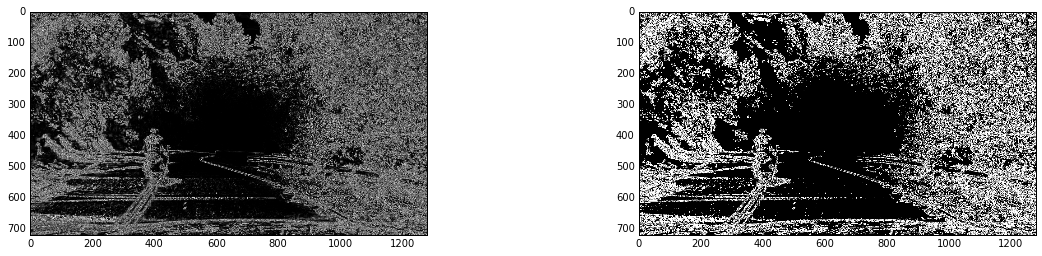

In [259]:
#now lets try plotting the difference between the original an undistorted images to see the shift
im_diff= (image-undist_image)**2
im_diff1 = np.sum(im_diff,axis=2)
imx = 255*(np.ones_like(im_diff1))
imy = imx- im_diff1
#print(im_diff1.shape)
#im_diff1= gaussian_blur(im_diff1)
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.imshow(im_diff1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imy, cmap ='gray')
plt.show()
im_diff,imx,imy,im_diff1 = 0,0,0,0

There is a lot of difference between image and undistorted image as the difference image has lot of data.From the above inference we can see that there will be significant amount of error if undistortion is not performed.

------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------

### Step2  :  Apply perspective transform on undistorted image to have a bird's eye view of the road. Warping the image to right region of interest does good help in further processing of the frame.

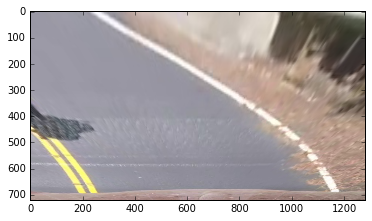

In [260]:
im = undist_image
shp = im.shape
#The perspective transformation in this scene is applied to have a birds eye view of the road to check the lane lines. 
#To do perspective transformation we need to mark points on the source image and create a destination image

# define four source points
y_min,y_max = shp[0]/1.49,shp[0]
x_mid = shp[1]/2
x1,x2,x3,x4 = 0.1*x_mid,0.8*x_mid,1.2*x_mid,1.9*x_mid

src = np.float32([[x1,y_max],[x2,y_min],[x3,y_min],[x4,y_max]])
dst = np.float32([[0,shp[0]],[0,0],[shp[1],0],[shp[1],shp[0]]])

warped,Mat,Mat_inv = warp_image(image,src,dst,(shp[1],shp[0]))

#cv2.putText(warped,'y_min = y/1.5',(10,500), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),2,cv2.LINE_AA)
plt.imshow(warped)
plt.show()
#cv2.imwrite(outdir+'/')
#cv2.imwrite(outdir+'/name.jpg',cv2.cvtColor(finished, cv2.COLOR_BGR2RGB))
#cv2.putText(warped,'y_min = y/1.49',(300,600), cv2.FONT_HERSHEY_SIMPLEX, 3,(0,255,255),10,cv2.LINE_AA)
#cv2.imwrite(outdir+'/bird-eye-view-y149.jpg',cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )

In [237]:
img_size = np.shape(image)
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - .9*np.uint(img_size[1]/2)
cbr_window = c_window + .9*np.uint(img_size[1]/2)
src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])


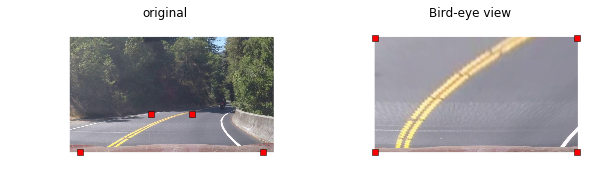

In [238]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
plt.axis('off');

In [ ]:
def continuous_transform(image)

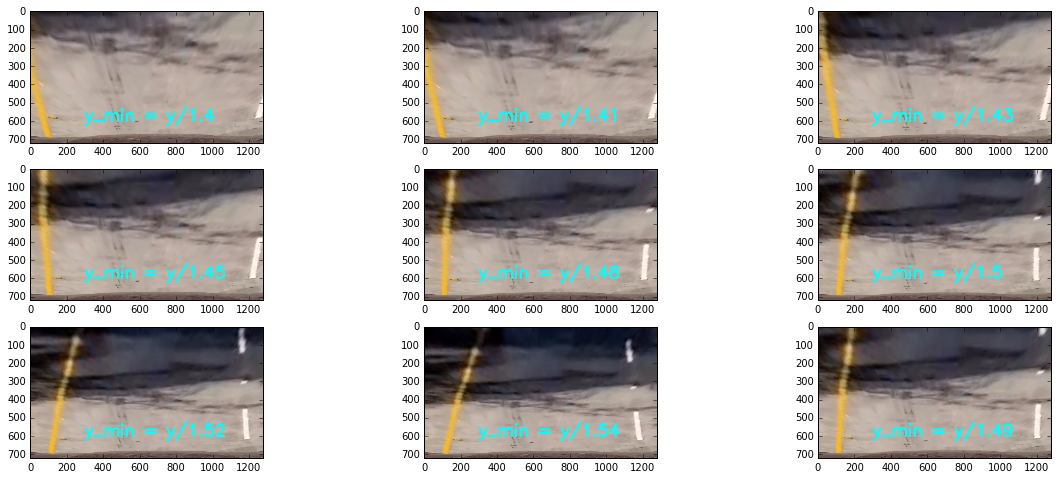

In [152]:
image_list = []
for filename in glob.glob('modelsol/*.jpg'):
    im=pimag.open(filename)
    image_list.append(im)

plt.figure(figsize=(20,8))
for i in range(3):
    for j in range(3):
        k=(3*(i))+j+1
        plt.subplot(3,3,k)
        plt.imshow(image_list[k-1])
plt.show()
        
        


From the above results it is clear to consider the source points with y_min = y/1.5

In [261]:
im = undist_image
shp = im.shape
y_min,y_max = shp[0]/1.5,shp[0]
x_mid = shp[1]/2
x1,x2,x3,x4 = 0.1*x_mid,0.8*x_mid,1.2*x_mid,1.9*x_mid

src = np.float32([[x1,y_max],[x2,y_min],[x3,y_min],[x4,y_max]])
dst = np.float32([[0,shp[0]],[0,0],[shp[1],0],[shp[1],shp[0]]])

warped,Mat,Mat_inv = warp_image(image,src,dst,(shp[1],shp[0]))


--------------------------------------------------------------------------------------------------------------------------------------

****************************************************************************************************************************************

### Step 3:  Shifting the colour space from RGB to either HSV or HSL helps to figure out more data with less effort. 
HSV values for Yellow range from [0,100,100] to [80,255,255], and for white colour they range from [0,0,210] to [200,50,255].'H' or HUE stands for the colour itself , 'S' stands for SATURATION or the amount of colour, and 'V' stands for VALUE or the amount of brighness applied over that colour. As the important aspect of this problem is to find lanes even with heavy variations of brightness, shifting the colour space from RGB to HSV will do a good job.

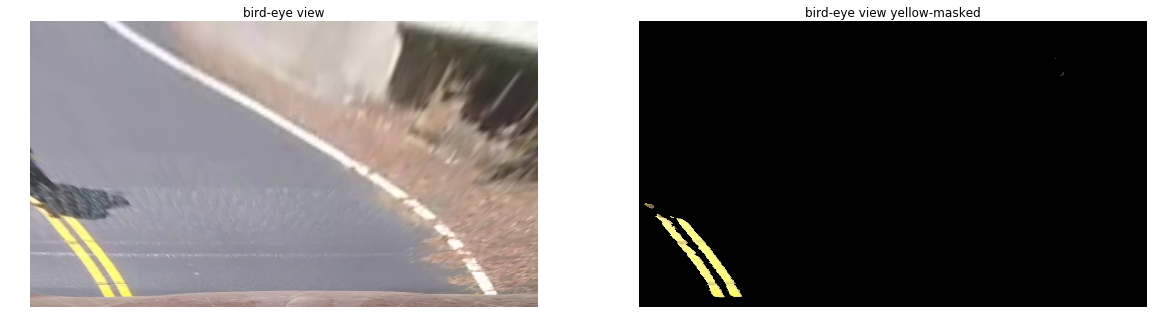

In [262]:
# yellow colour mask
HSV_image = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
y_hsv_low  = np.array([ 20,  80,50])
y_hsv_high = np.array([ 50, 255, 255])
yellow_masked = apply_color_mask(HSV_image,warped,y_hsv_low,y_hsv_high)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(yellow_masked)
plt.title('bird-eye view yellow-masked')
plt.axis('off');

The yellow mask didnot work well as there is some shadow on the lane but the mask was able to detect the lane at different light intensities

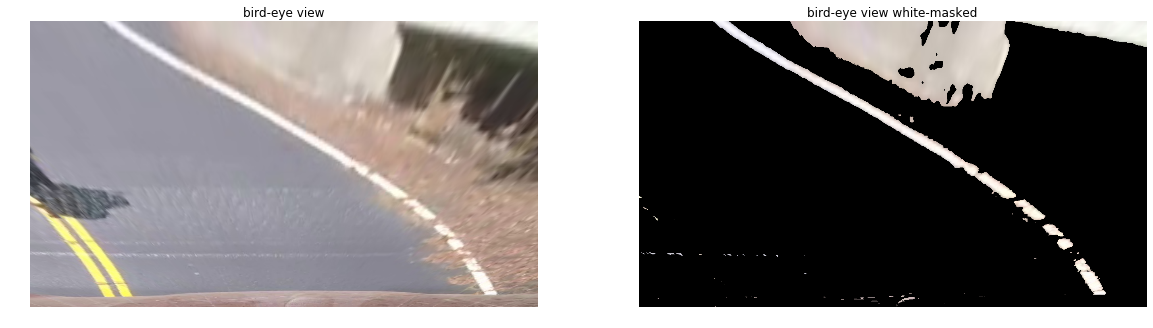

In [270]:
w_hsv_low  = np.array([ 0,   0,   200])
w_hsv_high = np.array([255,  40, 255])
res1 = apply_color_mask(HSV_image,warped,w_hsv_low,w_hsv_high)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view white-masked')
plt.axis('off');

The above filter was working well on white lanes.

shape of mask lane (720, 1280)


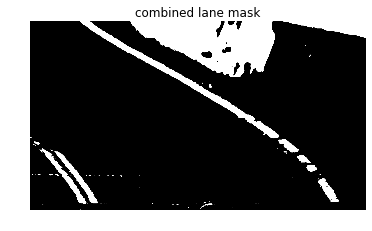

In [271]:
# combining both the colour masks
mask_yellow = color_mask(HSV_image,y_hsv_low,y_hsv_high)
mask_white = color_mask(HSV_image,w_hsv_low,w_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
print('shape of mask lane', mask_lane.shape)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

But we can see now that the lane is not perfectly identified so we also use edge detection methods in up coming steps.

************************************************************************************************************************************

------------------------------------------------------------------------------------------------------------------------------------------

### Step 4: Next step is to detect the edges from the masked image. 
Sobel filter is applied on H, L channels of the warped image as these channels show very mimimal change with lighting variations. Sobel filter is applied along X and Y directons independently and a bitwise OR operation is performed on the the masks to obtain a final mask. After many number of iterations the threshold values from 50 to 225 were choosen to be appropriate.

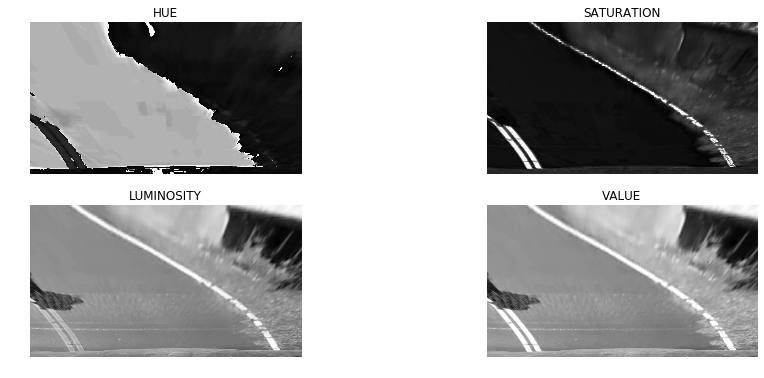

In [272]:
# Analyse H,S,L,V channels of the image.
HLS_image = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
plt.figure(figsize=(15,6))
plt.subplot(2,2,1)
plt.imshow(HLS_image[:,:,0],cmap='gray')
plt.title('HUE')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(HLS_image[:,:,2],cmap='gray')
plt.title('SATURATION')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(HLS_image[:,:,1],cmap='gray')
plt.title('LUMINOSITY')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(HSV_image[:,:,2],cmap='gray')
plt.title('VALUE')
plt.axis('off')
image_HLS = HLS_image

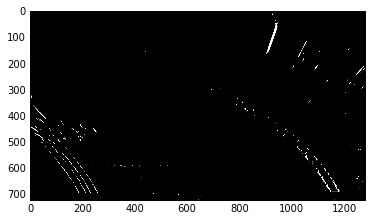

In [273]:
# Applying sobel filter to detect edges on L
img_gl = image_HLS[:,:,1]
img_abs_x = abs_sobel(img_gl,'x',5,(80,225))
img_abs_y = abs_sobel(img_gl,'y',5,(200,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')
sobelL = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

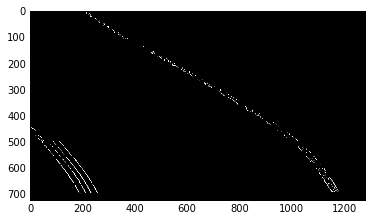

In [274]:
# Applying sobel filter to detect edges on S
img_gs = image_HLS[:,:,2]
img_abs_x = abs_sobel(img_gs,'x',5,(80,255))
img_abs_y = abs_sobel(img_gs,'y',5,(150,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')
sobelS = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

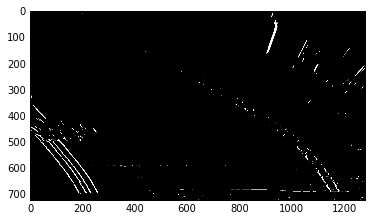

In [275]:
# Applying sobel filter to detect edges on V
img_gv = HSV_image[:,:,2]
img_abs_x = abs_sobel(img_gv,'x',5,(70,255))
img_abs_y = abs_sobel(img_gv,'y',5,(150,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')
sobelV = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

** The edges from L and V channel look the same. So i'm randomly considering L channel for edge detection.**

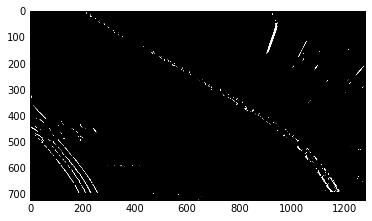

In [276]:
# Now combining edges from L and S channels
sobelLS = cv2.bitwise_or(sobelL,sobelS)
sobelLSV = cv2.bitwise_or(sobelLS,sobelV)
g_sobelLS = gaussian_blur(sobelLS,3)
plt.imshow(g_sobelLS,cmap='gray')
plt.show()

The above filter looks very much fine except for a little noise. This can work better when combined with previously found filter that is colour filter.

****************************************************************************************************************************************************

------------------------------------------------------------------------------------------------------------------------------------------

### Step 5: Colour and Sobel masks are combined to obtain potential lane locations.

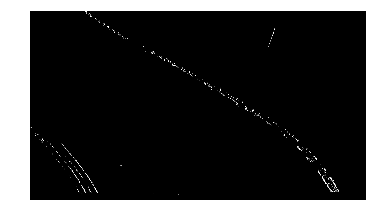

In [280]:
#Both colour and sobel are applied and gaussian is used to remove noise here
combined_filter = np.zeros_like(sobelLS)
combined_filter[(mask_lane>=0.5)&(sobelLS>=0.5)]=1
plt.imshow(gaussian_blur(combined_filter,1),cmap='gray')
plt.axis('off')
plt.show()

In [281]:
def pipeline(image):
    cal = pickle.load(open("camera_calibration.pkl" , "rb"))
    mtx_camera = cal[0]
    dist_camera = cal[1]
    image = mpimg.imread(open(image,'rb'))    
    undist_image = undistort_image(image,mtx_camera,dist_camera)
    shp = undist_image.shape
    y_min,y_max = shp[0]/1.5,shp[0]
    x_mid = shp[1]/2
    x1,x2,x3,x4 = 0.1*x_mid,0.8*x_mid,1.2*x_mid,1.9*x_mid

    src = np.float32([[x1,y_max],[x2,y_min],[x3,y_min],[x4,y_max]])
    dst = np.float32([[0,shp[0]],[0,0],[shp[1],0],[shp[1],shp[0]]])

    warped,Mat,Mat_inv = warp_image(image,src,dst,(shp[1],shp[0]))
    
    HSV_image = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)
    y_hsv_low  = np.array([ 0,  100,100])
    y_hsv_high = np.array([ 80, 255, 255])
    yellow_mask = apply_color_mask(HSV_image,warped,y_hsv_low,y_hsv_high)
    
    w_hsv_low  = np.array([ 20,   0,   190])
    w_hsv_high = np.array([ 255,  80, 255])
    white_mask = apply_color_mask(HSV_image,warped,w_hsv_low,w_hsv_high)
    
    mask_yellow = color_mask(HSV_image,y_hsv_low,y_hsv_high)
    mask_white = color_mask(HSV_image,w_hsv_low,w_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
    
    
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    img_gl = image_HLS[:,:,1]
    img_abs_x = abs_sobel(img_gl,'x',5,(50,225))
    img_abs_y = abs_sobel(img_gl,'y',5,(50,225))
    sobelL = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel(img_gs,'y',5,(50,255))
    sobelS = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    sobelLS = cv2.bitwise_or(sobelL,sobelS)
    g_sobelLS = gaussian_blur(sobelLS,3)
    combined_filter = np.zeros_like(sobelLS)
    combined_filter[(mask_lane>=0.5)|(sobelLS>=0.5)]=1
    res = gaussian_blur(combined_filter,1)
    
    return image,res   

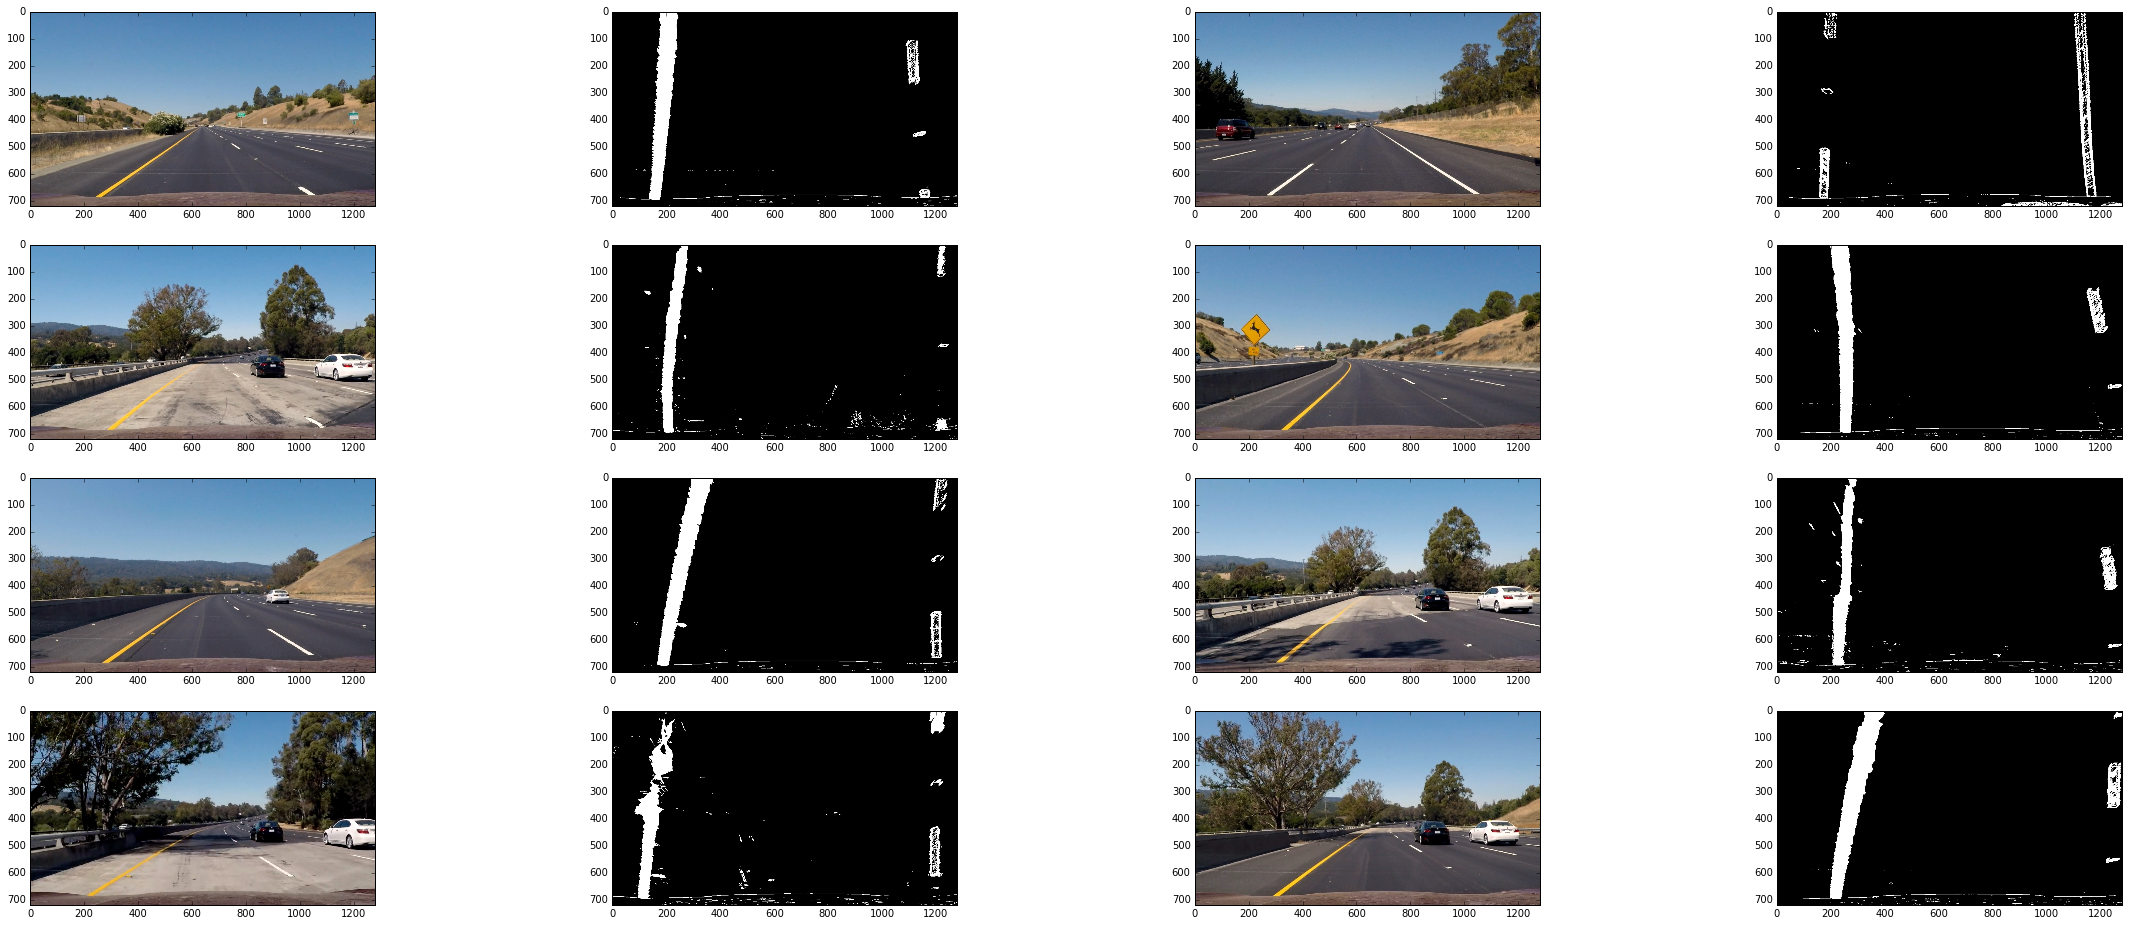

In [135]:
result_list = []
image_list = []
for filename in glob.glob('test_images/*.jpg'):
    #im=pimag.open(filename)
    image,result = pipeline(filename)
    image_list.append(image)
    result_list.append(result)
    
#print(len(result_list))

plt.figure(figsize=(40,16))
for i in range(4):
    for j in range(4):
        k=int ((2*i)+(j/2))
        l = 4*i +j+1
        if j%2==0:
            plt.subplot(4,4,l)
            #print('i,evenj,k',i,j,k)
            plt.imshow(image_list[k],cmap='gray')            
        if j%2==1:
            plt.subplot(4,4,l)
            #print('i,oddj,k',i,j,k)
            plt.imshow(result_list[k],cmap='gray')
plt.show()
        

The threshold values are obtained after many number of iterations and the choosedn values are working good enough to check through histogram. The choosen threshold values are 
1. for white : w_low = np.array([ 0, 0, 190]) w_high = np.array([140, 25, 255])
2. for yellow : y_low = np.array([ 0, 100,100]) y_high = np.array([ 80, 255, 255])

*****************************************************************************************************************************************

******************************************************************************************************************************************

## Problem2 Solution

### Step 6: Consider only half of the image that is masked and compute histogram
we find the lane locations at the two peaks of histogram corresponding to left and right lanes of the road in the masked image.

peak left position : 170
right peak position : 1109


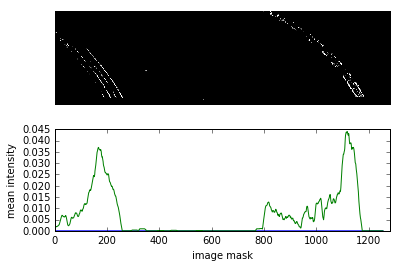

In [282]:
filtersize = int(shp[1]/50.)
mean_lane = np.mean(combined_filter[int(shp[0]/2):,:],axis=0)
mean_lane = moving_average(mean_lane,filtersize)
plt.subplot(2,1,1)
plt.imshow(combined_filter[int(shp[0]/2):,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.1)
plt.plot(mean_lane)
plt.xlabel('image mask')
plt.ylabel('mean intensity')
plt.xlim(0,shp[1])
tips = find_peaks_cwt(mean_lane,[100], max_distances=[800])
#print(len(tips))
window_size=50
val_ind = np.array([mean_lane[tips[i]] for i in range(len(tips)) ])
ind_sorted = np.argsort(-val_ind)
ind_peakR = tips[ind_sorted[0]]
ind_peakL = tips[ind_sorted[1]]
#print('ind_sorted',ind_sorted)
print('peak left position :',ind_peakL)
print('right peak position :',ind_peakR)

In [283]:
listo=[]
lista=[]
for i in range(len(mean_lane)):
    if mean_lane[i] != False:
        listo.append(i)
        lista.append(mean_lane[i])
#print(listo)
#print('lista', lista)

170 1109


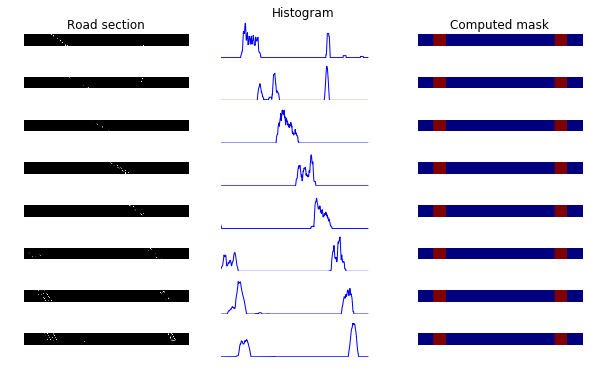

In [284]:
# As the peak locations are found we use windowing to find the potential locations of the lane
n_vals = 8
# CREATING WINDOWS
# Get windows for bottom frame
ind_min_L = ind_peakL-50
ind_max_L = ind_peakL+50
ind_min_R = ind_peakR-50
ind_max_R = ind_peakR+50

mask_L_poly = np.zeros_like(combined_filter)
mask_R_poly = np.zeros_like(combined_filter)
print(ind_peakL,ind_peakR)
ind_peakR_prev = ind_peakR
ind_peakL_prev = ind_peakL

plt.figure(figsize=(10,6))
# Slide window up for each 1/8th of image
for i in range(8):
    img_y1 = int(shp[0]-shp[0]*i/8)
    img_y2 = int(shp[0]-shp[0]*(i+1)/8)    
    mean_lane_y = np.mean(combined_filter[img_y2:img_y1,:],axis=0)
    mean_lane_y = moving_average(mean_lane_y,filtersize)
    indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])    
    # If 2 peaks are detected assign peaks to correct side.        
    if len(indexes)>1.5:
        val_ind = np.array([mean_lane[tips[i]] for i in range(len(tips)) ])
        ind_sorted = np.argsort(-val_ind)
        ind_peakR = tips[ind_sorted[0]]
        ind_peakL = tips[ind_sorted[1]]
        if ind_peakR<ind_peakL:
            ind_temp = ind_peakR
            ind_peakR = ind_peakL
            ind_peakL = ind_temp
            
    else:
        # If 1 peak is detected, assign peak to closest peak in previous 1/8th image.
        if len(tips)==1:
            if np.abs(tips[0]-ind_peakR_prev)<np.abs(tips[0]-ind_peakL_prev):
                ind_peakR = tips[0]
                ind_peakL = ind_peakL_prev
            else:
                ind_peakL = tips[0]
                ind_peakR = ind_peakR_prev
        else:
            ind_peakL = ind_peakL_prev
            ind_peakR = ind_peakR_prev
            
                
    if np.abs(ind_peakL-ind_peakL_prev)>=100:
        ind_peakL = ind_peakL_prev
    if np.abs(ind_peakR-ind_peakR_prev)>=100:
        ind_peakR = ind_peakR_prev
    
            
    mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
    mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1. 
   
    ind_peakL_prev = ind_peakL
    ind_peakR_prev = ind_peakR    
    

    plt.subplot(8,3,25-3*i-2)
    #plt.imshow(combined_filter[img_y2:img_y1,:],cmap='gray')
    plt.plot(mean_lane_y)
    if i==7:
        plt.title('Histogram')
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    plt.axis('off')  
    plt.subplot(8,3,25-3*i-3)
    plt.imshow(combined_filter[img_y2:img_y1,:],cmap='gray')
    #plt.plot(mean_lane_y)
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    if i==7:
        plt.title('Road section')
    plt.axis('off') 
    plt.subplot(8,3,25-3*i-1)
    plt.imshow(mask_L_poly[img_y2:img_y1,:]+mask_R_poly[img_y2:img_y1,:])
    plt.axis('off')
    if i==7:
        plt.title('Computed mask')   
    


In [285]:
def get_initial_mask(img,window_size):
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = int(img_size[1]/50.)
    mean_ln = np.mean(img[int(img_size[0]/2):,:],axis=0)
    mean_ln = moving_average(mean_ln,mov_filtsize)
    
    indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])
    print('indexes',len(indexes))

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    print('abraca',ind_peakL,ind_peakR)
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    diff_R = 0
    diff_L = 0
    for i in range(8):
        

        
        img_y1 = int(img_size[0]-img_size[0]*i/8)
        img_y2 = int(img_size[0]-img_size[0]*(i+1)/8)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
            if len(indexes)==1:
                if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev+diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev+diff_R
            else:
                ind_peakL = ind_peakL_prev+diff_R
                ind_peakR = ind_peakR_prev+diff_R
            
                
        if np.abs(ind_peakL-ind_peakL_prev)>=100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR-ind_peakR_prev)>=100:
            ind_peakR = ind_peakR_prev
    
            
        mask_L_poly[int(img_y2):int(img_y1),int(ind_peakL-window_size):int(ind_peakL+window_size)] = 1.     
        mask_R_poly[int(img_y2):int(img_y1),int(ind_peakR-window_size):int(ind_peakR+window_size)] = 1.
        
        if i == 0:
            window_size= window_size/1
   
        if i>0:
            diff_R = ind_peakL-ind_peakL_prev
            diff_L = ind_peakR-ind_peakR_prev

    
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
        
        
    return mask_L_poly,mask_R_poly

indexes 2
abraca 1109 170


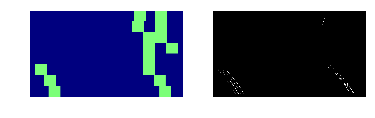

In [286]:
mask_L_poly,mask_R_poly = get_initial_mask(combined_filter,50)

plt.subplot(1,2,1)
plt.imshow(mask_R_poly+mask_L_poly)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.bitwise_and(combined_filter,combined_filter,mask=mask_R_poly+mask_L_poly),cmap='gray')